In [1]:
import jax.numpy as jnp
import jax
from jax import grad, random, jacrev
from functools import partial

import numpy as np
import scipy.linalg as la
import jax.scipy.linalg as jla

import matplotlib.pyplot as plt

key = random.PRNGKey(0)

In [2]:
# Define the radial basis function

@jax.jit
def gaussian_rbf(x, c, epsilon):
    """ Gaussian Radial Basis Function """
    return jnp.exp(-epsilon * jnp.linalg.norm(x - c, axis=-1)**2)

@jax.jit
def phs_rbf(x, c, m):
    """ Gaussian Radial Basis Function """
    return jnp.linalg.norm(x - c, axis=-1)**2**m


@partial(jax.jit, static_argnames=['rbf'])
def setup_system_matrix(X, epsilon, rbf=gaussian_rbf):
    """ Sets up the system matrix for the RBF-FD method """

    X = jnp.expand_dims(X, axis=0)

    A = rbf(X, jnp.swapaxes(X, 0 , 1), epsilon)

    return A

@partial(jax.jit, static_argnames=['rbf', 'boundary'])
def laplacian_operator(X, y, epsilon, boundary=False, rbf=gaussian_rbf):
    """ Approximates the Laplacian operator using RBF-FD """
    N = len(X)
    A = setup_system_matrix(X, epsilon, rbf=rbf)

    rhs = jnp.zeros(N)

    laplace_phi = jacrev(grad(rbf, argnums=0))

    for i in range(N):
            
        if not boundary:
            rhs = rhs.at[i].set(jnp.trace(laplace_phi(X[i], y+1e-6 , epsilon)))
        elif boundary:
            rhs = rhs.at[i].set(0.0)  # Set boundary conditions here. These are dircihlet conditions for f(y) = 0 

    w = jla.solve(A, rhs)

    return w

def laplacian_system(X, epsilon, rbf=gaussian_rbf):
    """ This solves for the laplace weights for the rbf nodes / laplacian operator"""

    N = len(X)

    L = np.zeros((N, N))

    for i in range(N):
        
        #b = True if i == 0 or i == N-1 else False
        L[i] = laplacian_operator(X, X[i], epsilon, boundary=False, rbf=rbf)

    return L


(50, 1)


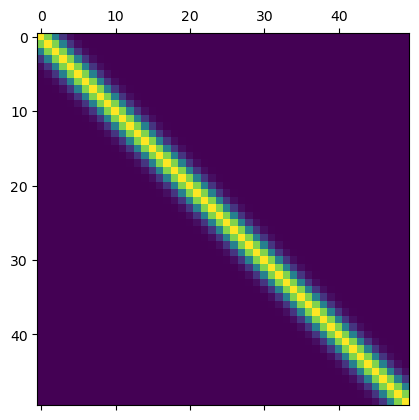

In [3]:
N = 50
# Set up the nodes and epsilon
D = np.linspace(0, 1, N).reshape(-1, 1)  # 1D nodes in the interval [0, 1]

epsilon = 500.0

print(D.shape)


import scipy.spatial as kdtree

tree = kdtree.KDTree(D)

A = setup_system_matrix(D, epsilon, rbf=gaussian_rbf)

plt.matshow(A)

In [ ]:

@dask.delayed
def laplacian_operator_parallel(X, y, epsilon, boundary=False, rbf=gaussian_rbf):
    """ Approximates the Laplacian operator using RBF-FD """
    N = len(X)
    A = setup_system_matrix(X, epsilon, rbf=rbf)

    rhs = jnp.zeros(N)

    laplace_phi = jacrev(grad(rbf, argnums=0))

    for i in range(N):
            
        if not boundary:
            rhs[i] = jnp.trace(laplace_phi(X[i], y+1e-6 , epsilon))
        elif boundary:
            #rhs[i] = 0.0 # Set boundary conditions here. These are dircihlet conditions for f(y) = 0
            rhs = rhs.at[i].set(0.0) 

    w = la.solve(A, rhs)

    return w

@dask.delayed
def laplacian_system_parallel(X, epsilon, rbf=gaussian_rbf):
    """ This solves for the laplace weights for the rbf nodes / laplacian operator"""

    N = len(X)

    L = jnp.zeros((N, N))

    for i in range(N):
        
        b = True if i == 0 or i == N-1 else False
        L[i] = laplacian_operator_parallel(X, X[i], epsilon, boundary=b, rbf=rbf)

    return L

N = 50
# Set up the nodes and epsilon
D = np.linspace(0, 1, N).reshape(-1, 1)  # 1D nodes in the interval [0, 1]

epsilon = 1000.0

# Set up the differential operator (Laplacian in this case)
L = laplacian_system(D, epsilon, rbf=gaussian_rbf)

# Compute the eigenvalues and eigenvectors
test_eval, test_evec = la.eig(L)


In [10]:
# Set up the nodes and epsilon
N = 40  # Number of nodes
X = (np.logspace(0, 1, N).reshape(-1, 1)  -1) /10  # 1D nodes in the interval [0, 1]

epsilon = 650.0

# Set up the differential operator (Laplacian in this case)
L = laplacian_system(X, epsilon, rbf=gaussian_rbf)

# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors_non = la.eig(L)

index = np.argsort(eigenvalues)

eigenvalues = eigenvalues[index]
eigenvectors_non = eigenvectors_non[:,index]

eigenvalues, eigenvectors_non

(array([-3.73384789e+04+0.j, -3.25892100e+04+0.j, -2.74460042e+04+0.j,
        -2.43717901e+04+0.j, -2.11703882e+04+0.j, -1.88724608e+04+0.j,
        -1.65915844e+04+0.j, -1.46828909e+04+0.j, -1.29425396e+04+0.j,
        -1.14071734e+04+0.j, -1.00686236e+04+0.j, -8.87786632e+03+0.j,
        -7.84512773e+03+0.j, -6.93483895e+03+0.j, -6.13930887e+03+0.j,
        -5.44213504e+03+0.j, -4.83079275e+03+0.j, -4.29517060e+03+0.j,
        -3.82506977e+03+0.j, -3.41116533e+03+0.j, -3.04296805e+03+0.j,
        -2.70804842e+03+0.j, -2.39595347e+03+0.j, -2.10250833e+03+0.j,
        -1.82915701e+03+0.j, -1.58231486e+03+0.j, -1.38165234e+03+0.j,
        -1.22887638e+03+0.j, -1.05432524e+03+0.j, -8.70241437e+02+0.j,
        -6.98893740e+02+0.j, -5.45689226e+02+0.j, -4.11651457e+02+0.j,
        -2.96311594e+02+0.j, -1.98564609e+02+0.j, -1.17698897e+02+0.j,
        -5.49273887e+01+0.j, -1.42022570e+01+0.j,  2.06528484e+03+0.j,
         1.36252070e+04+0.j]),
 array([[-1.91996684e-01, -3.00524341e-02, -6.

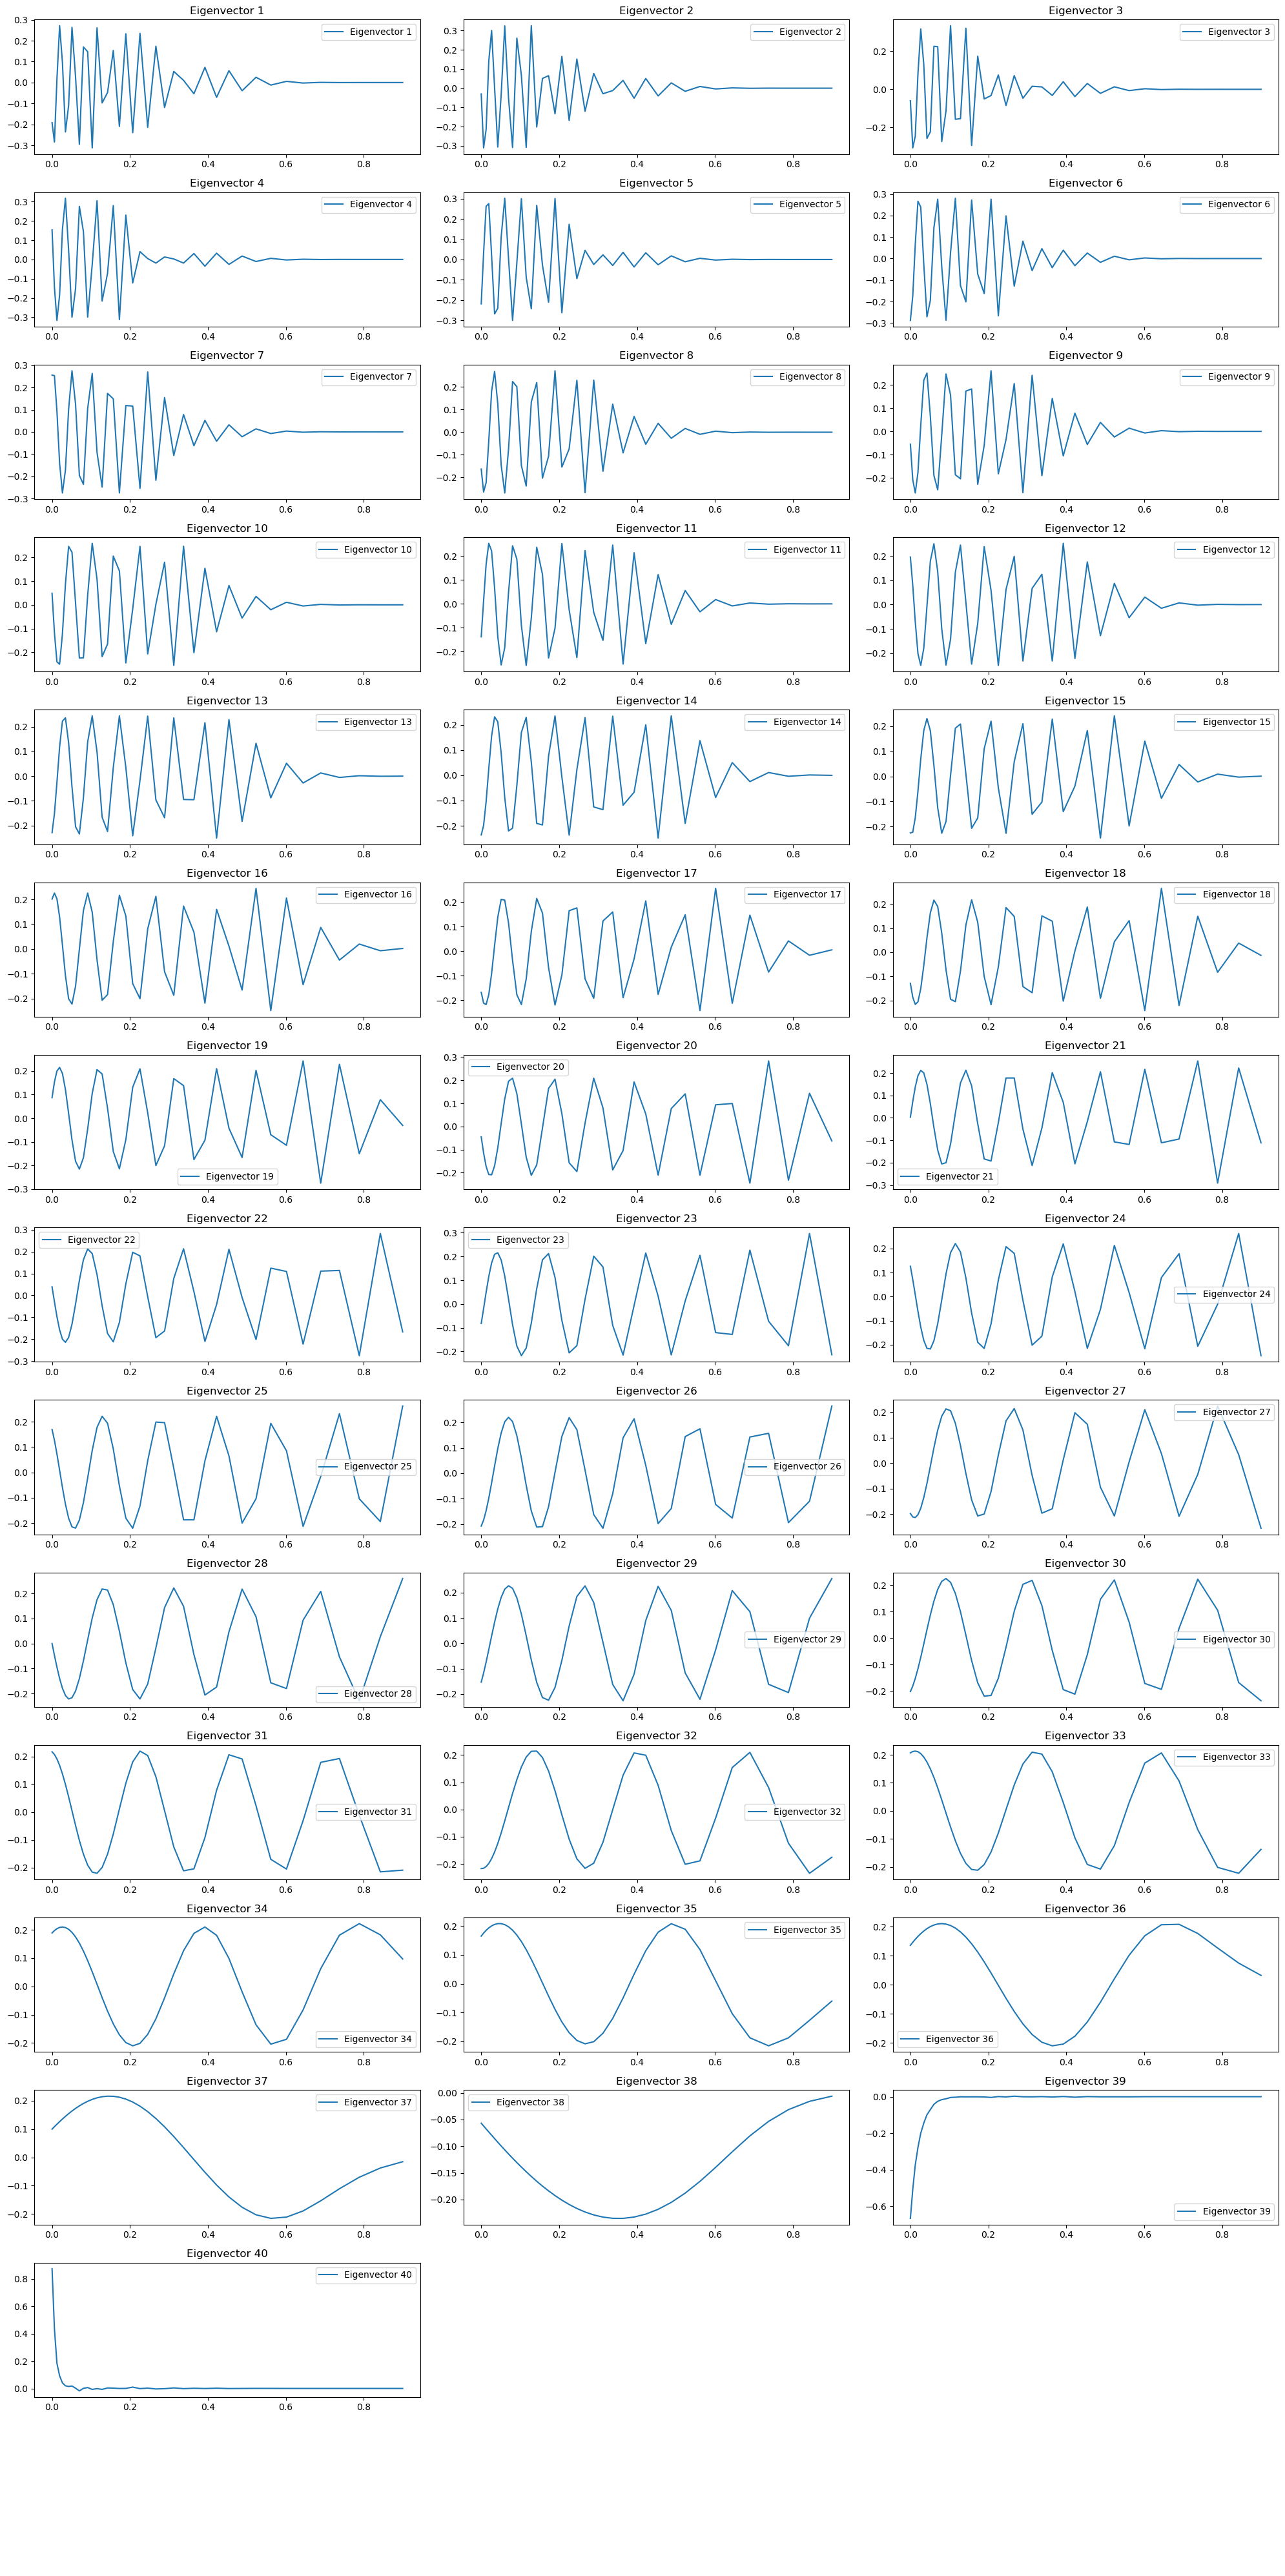

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(15, 3, figsize=(20, 40))

for i, ax in enumerate(axs.flatten()):

    if i > N-1:
        ax.axis("off")
        continue

    ax.plot(X, eigenvectors_non[:, i], label=f"Eigenvector {i+1}")
    ax.set_title(f"Eigenvector {i+1}")
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Set up the nodes and epsilon
Y = np.linspace(0, 1, N).reshape(-1, 1)  # 1D nodes in the interval [0, 1]

epsilon = 1000.0

# Set up the differential operator (Laplacian in this case)
L = laplacian_system(Y, epsilon, rbf=gaussian_rbf)

# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors_uniform = la.eig(L)

eigenvalues, eigenvectors_uniform

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 3, figsize=(15, 40))

for i, ax in enumerate(axs.flatten()):

    if i > N-1:
        ax.axis("off")
        continue

    ax.plot(Y, eigenvectors_uniform[:, i], label=f"Eigenvector {i+1}")
    ax.set_title(f"Eigenvector {i+1}")
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(10, 5, figsize=(25, 50))

eigenbasis_2d = np.kron(eigenvectors_uniform, eigenvectors_non).reshape(N, N, N**2)

X_mesh, Y_mesh = np.meshgrid(X, Y)

for i, ax in enumerate(axs.flatten()):

    if i > N**2-1:
        ax.axis("off")
        continue

    # Plot the function values as colors in 2D
    #ax.imshow(eigenbasis_2d[:,:,i], cmap='hot', interpolation='nearest')
    ax.pcolormesh(X_mesh, Y_mesh, eigenbasis_2d[:,:,i], cmap='bone')
    ax.set_title(f"Eigenbasis {i+1}")

plt.tight_layout()
plt.show()





